In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs
from gaussian_process import Multifidelity_GP
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib notebook
np.random.seed(1234)

In [2]:
def f_H(x):
    #1-D
    #optimum at x=0.96609, f(x)=-1.48907
    return -(1.4-3*x)*np.sin(18*x)

def f_L(x):
    return 0.5*f_H(x) + 2.0*(x-0.5) - 1.0

def Normalize(X, X_m, X_s):
    return (X-X_m)/(X_s)

In [3]:
N_H = 10
N_L = 20
D = 1
lb = 0.0*np.ones(D)
ub = 1.2*np.ones(D)
noise_L = 0.1
noise_H = 0.1

Normalize_input_data = 0
Normalize_output_data = 0

<IPython.core.display.Javascript object>


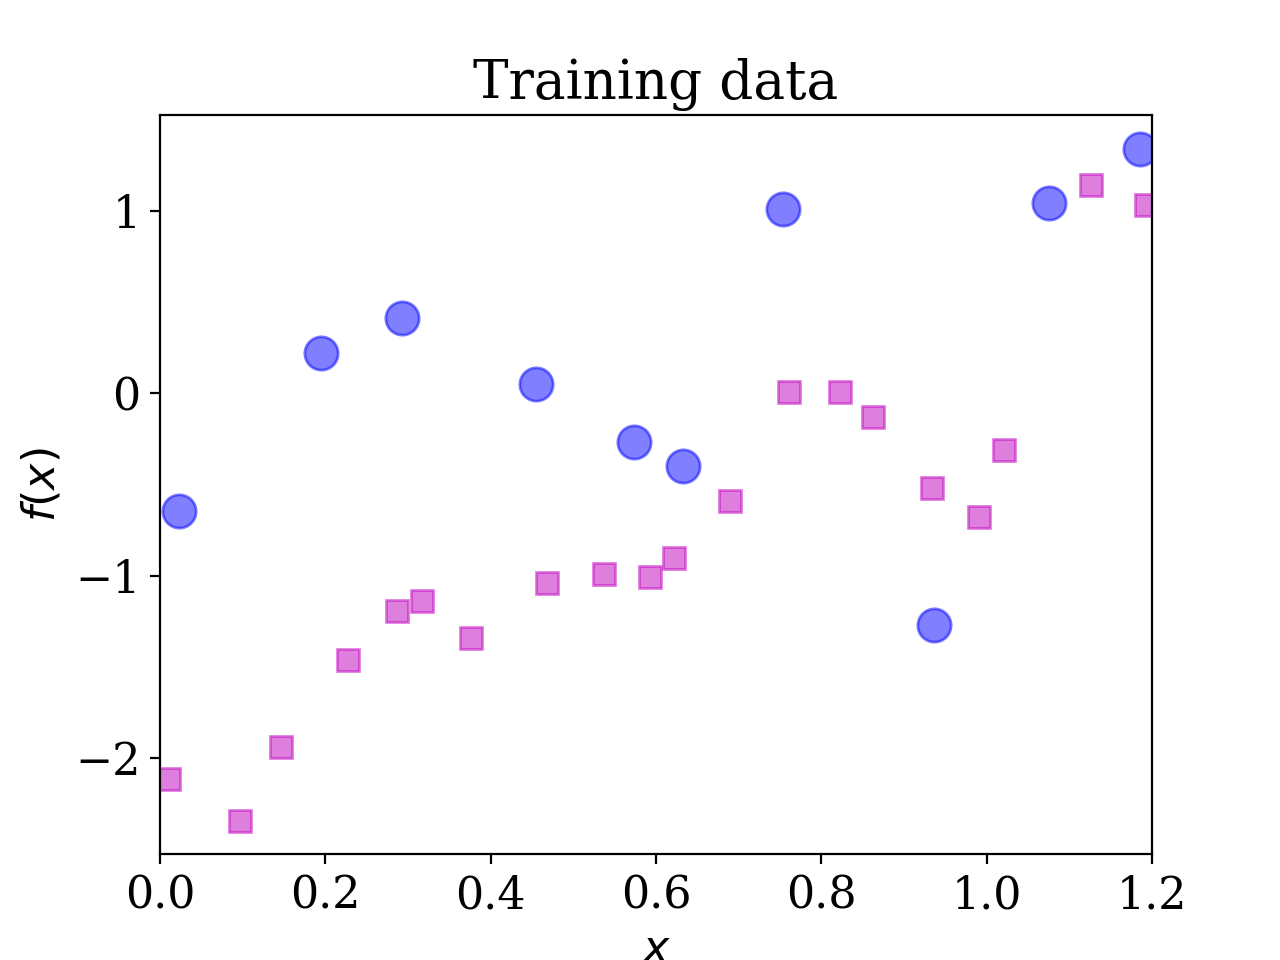

Text(0, 0.5, '$f(x)$')

In [4]:
# Training data 
np.random.seed(1234)
X_L = lb + (ub-lb)*lhs(D, N_L)
y_L = f_L(X_L) + noise_L*np.random.randn(N_L,D)

np.random.seed(1234)
X_H = lb + (ub-lb)*lhs(D, N_H)
y_H = f_H(X_H) + noise_H*np.random.randn(N_H,D)

# Test data
nn = 200
X_star = np.linspace(lb, ub, nn)
y_star = f_H(X_star)

 #  Normalize Input Data
if Normalize_input_data == 1:
    X = np.vstack((X_L,X_H))
    X_m = np.mean(X, axis = 0)
    X_s = np.std(X, axis = 0)   
    X_L = Normalize(X_L, X_m, X_s)
    X_H = Normalize(X_H, X_m, X_s)
    lb = Normalize(lb, X_m, X_s)
    ub = Normalize(ub, X_m, X_s)
    X_star = Normalize(X_star, X_m, X_s)

#  Normalize Output Data
if Normalize_output_data == 1:
    y = np.vstack((y_L,y_H))
    y_m = np.mean(y, axis = 0)
    y_s = np.std(y, axis = 0)   
    y_L = Normalize(y_L, y_m, y_s)
    y_H = Normalize(y_H, y_m, y_s)
    y_star = Normalize(y_star, y_m, y_s)
    
# Plot the training data
plt.figure(facecolor='w')
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=16)
plt.plot(X_H,y_H,'bo', markersize = 12, alpha = 0.5, label = "Data")
plt.plot(X_L,y_L,'ms', markersize = 8, alpha = 0.5, label = "Data")
plt.title("Training data")
ax = plt.gca()
ax.set_xlim([lb[0], ub[0]])
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

In [5]:
# Define model
model = Multifidelity_GP(X_L, y_L, X_H, y_H)

Total number of parameters: 7


In [6]:
# Train 
model.train()

Log likelihood 92.45511937789146
Log likelihood 53.070909943400224
Log likelihood 37.94011082677658
Log likelihood 32.09985132194247
Log likelihood 28.284901966519584
Log likelihood 27.185246607879716
Log likelihood 26.61705897168089
Log likelihood 24.717197485075495
Log likelihood 21.035599131562133
Log likelihood 20.51164483862418
Log likelihood 18.61401153277894
Log likelihood 18.332592016753885
Log likelihood 17.949429738122745
Log likelihood 17.39601523274091
Log likelihood 17.2598342711038
Log likelihood 17.24590880556765
Log likelihood 17.237211303171488
Log likelihood 16.772913174407876
Log likelihood 16.577909806500433
Log likelihood 16.39579699701489
Log likelihood 15.697747837469947
Log likelihood 15.11492200015668
Log likelihood 13.795638463594042
Log likelihood 13.279741318285588
Log likelihood 12.961138804668742
Log likelihood 12.849104347745286
Log likelihood 12.403461505909654
Log likelihood 12.098555242050434
Log likelihood 12.009735769273261
Log likelihood 11.99266172

Relative L2 error u: 0.14528248499350763


<IPython.core.display.Javascript object>


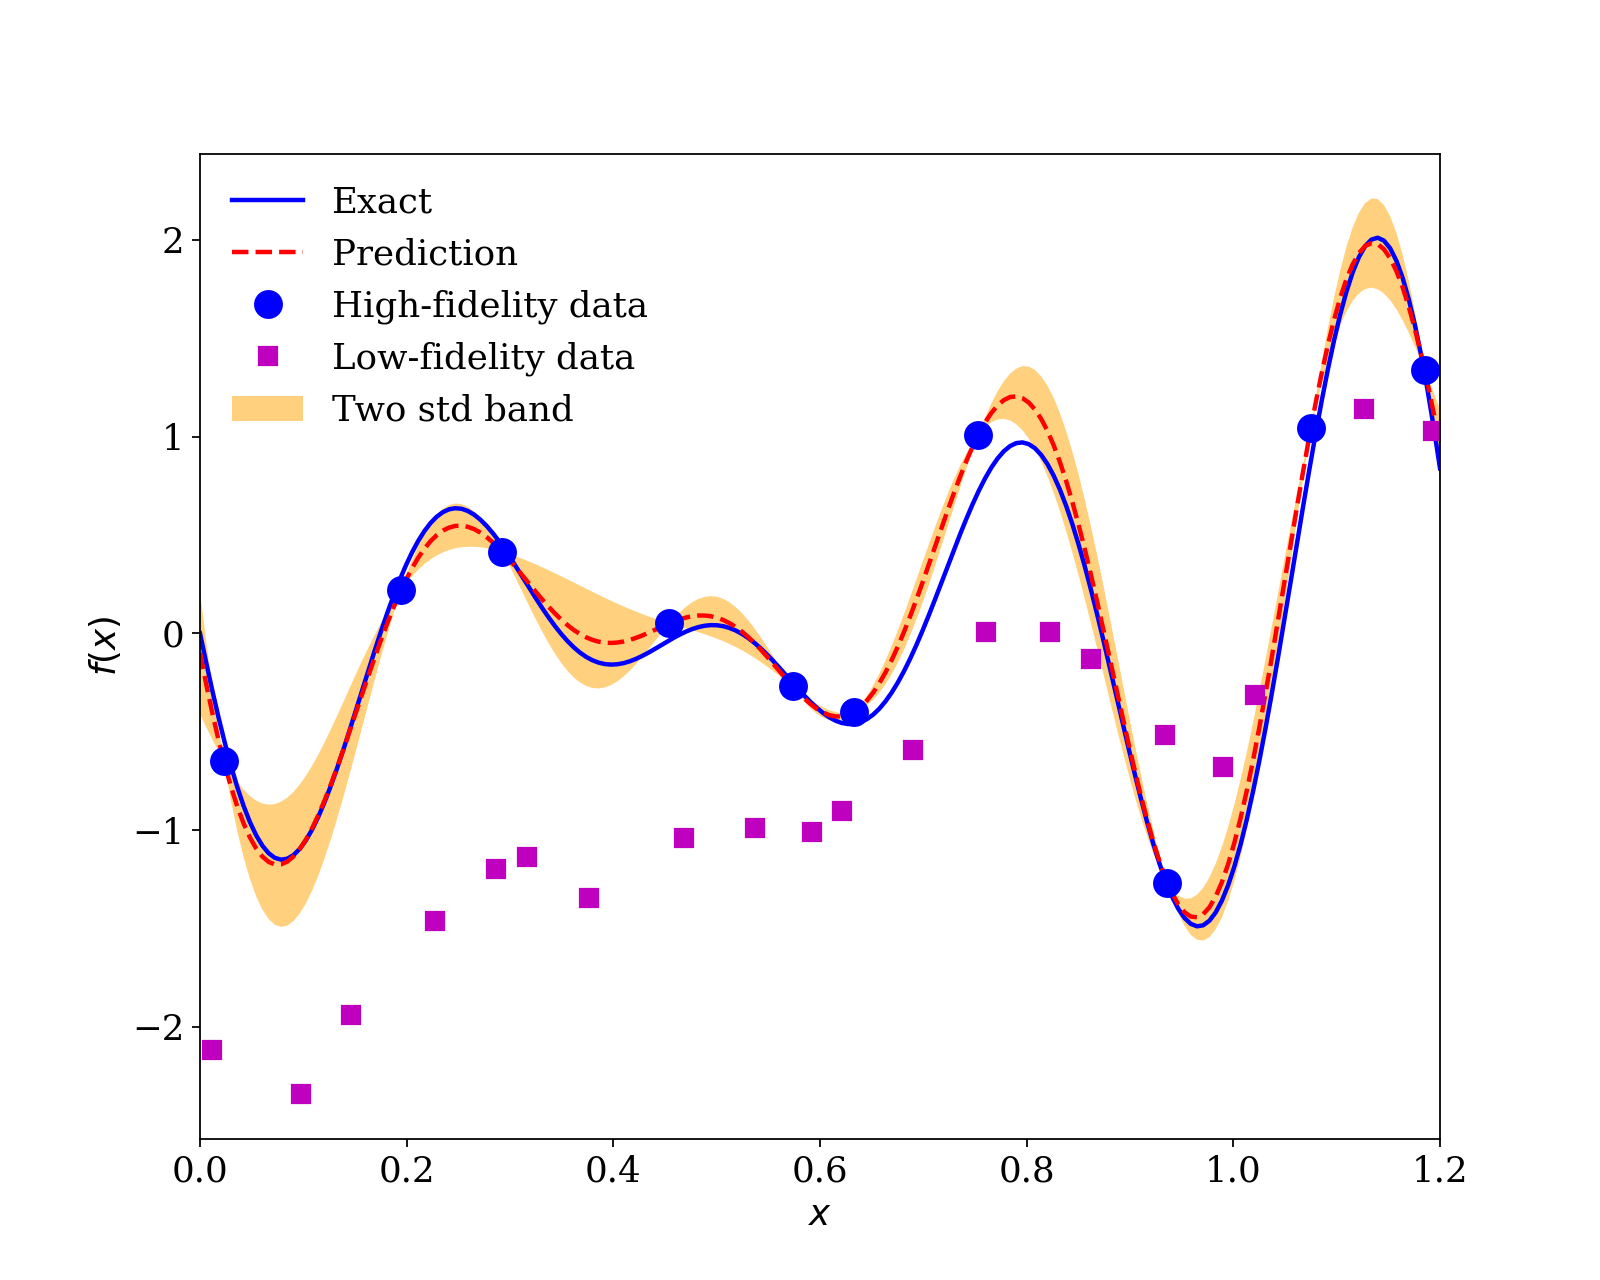

Text(0, 0.5, '$f(x)$')

In [7]:
# Predict
y_pred, y_var = model.predict(X_star)
y_var = np.abs(np.diag(y_var))

# Check accuracy                       
error = np.linalg.norm(y_pred-y_star,2)/np.linalg.norm(y_star,2)
print(f"Relative L2 error u: {error}")

# Plot
plt.figure(1, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=16)
plt.plot(X_star, y_star, 'b-', label = "Exact", linewidth=2)
plt.plot(X_star, y_pred, 'r--', label = "Prediction", linewidth=2)
lower = y_pred - 2.0*np.sqrt(y_var[:,None])
upper = y_pred + 2.0*np.sqrt(y_var[:,None])
plt.fill_between(X_star.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
plt.plot(X_H,y_H,'bo', markersize = 12, label = "High-fidelity data")
plt.plot(X_L,y_L,'ms', markersize = 8, label = "Low-fidelity data")
plt.legend(frameon=False,loc='upper left')
ax = plt.gca()
ax.set_xlim([lb[0], ub[0]])
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

In [8]:
print(y_star[y_pred==y_pred.min()]--1.48907)

[0.0003903]


In [9]:
def booth(X):
    #2-D
    #optimum at X=[1,3] f(X)=0
    X = np.atleast_2d(X)
    x = X[:, 0]
    y = X[:, 1]
    return((x+2*y-7)**2+(2*x+y-5)**2)

In [10]:
def booth_l(X):
    X = np.atleast_2d(X)
    return(0.23 * booth(X)+X[:,0]+X[:,1]**2+6)

In [11]:
N_H = 10
N_L = 20
D = 2
lb = -5.0
ub = 5.0
noise_L = 0.00
noise_H = 0.00

[[884.         871.12172227 858.34547495 ... 153.69901031 158.79848995
  164.        ]]


<IPython.core.display.Javascript object>


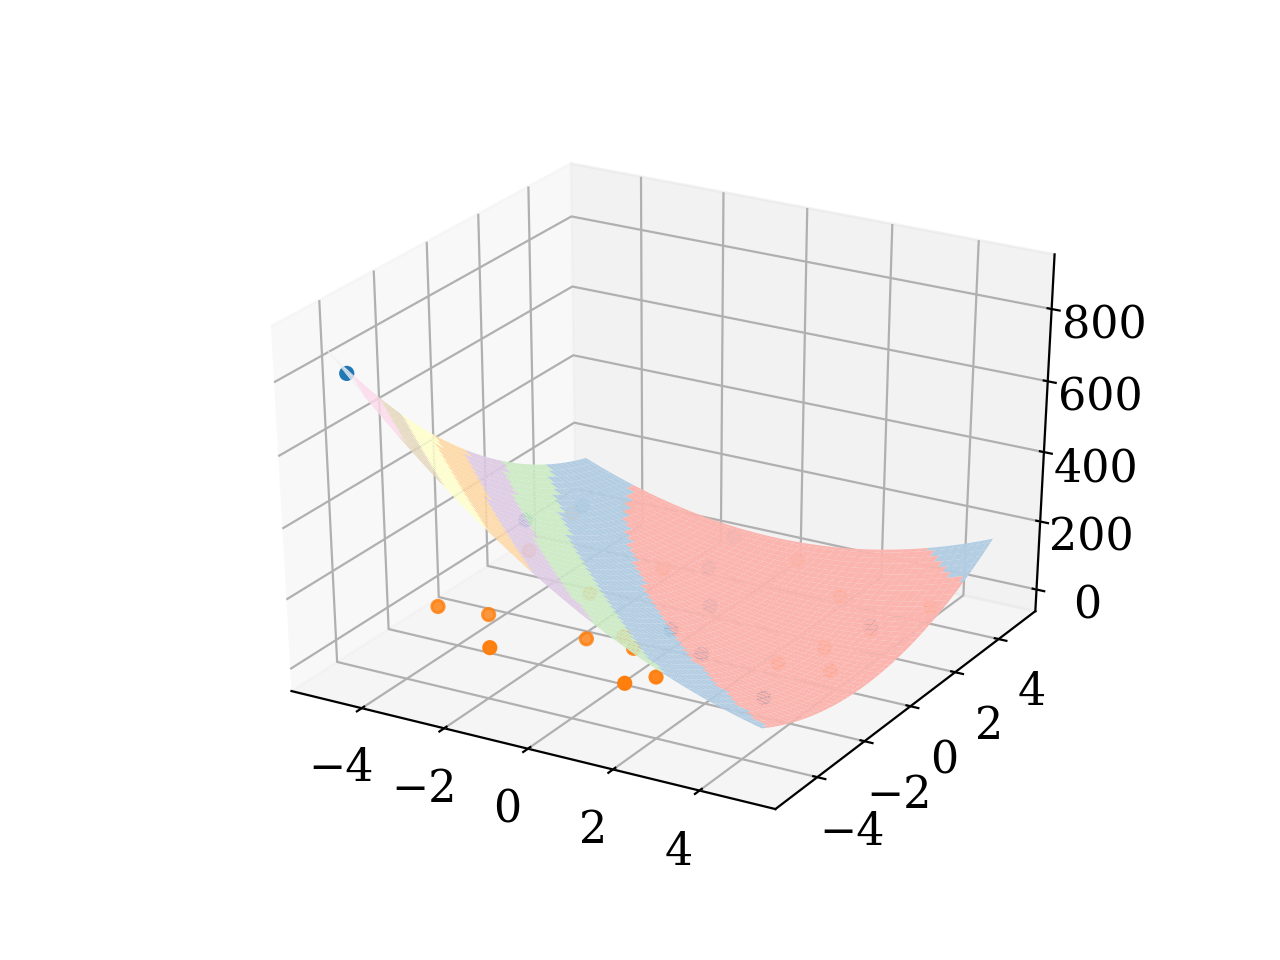

In [12]:
# Training data    
X_L = lb + (ub-lb)*lhs(D, N_L)
y_L = booth_l(X_L)
y_L = np.atleast_2d(y_L).T

X_H = lb + (ub-lb)*lhs(D, N_H)
y_H = booth(X_H)
y_H = np.atleast_2d(y_H).T

# Test data
nn = 100
x_star = np.linspace(lb, ub, nn)
xx, yy = np.meshgrid(x_star, x_star)

X_star = []
for i in x_star:
    for n in x_star:
        X_star.append([i,n])
X_star = np.array(X_star)
y_star_temp = np.array([booth(X_star)])
print(y_star_temp)
y_star = y_star_temp.reshape(nn,nn)

# Plot the training data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_H[:,0], X_H[:,1], y_H)
ax.scatter(X_L[:,0],X_L[:,1], y_L)
ax.plot_surface(xx, yy, y_star, cmap=cm.Pastel1)
plt.show()

In [13]:
# Define model
model = Multifidelity_GP(X_L, y_L, X_H, y_H)

Total number of parameters: 9


In [14]:
# Train 
model.train()

Log likelihood 69443.3942964476
Log likelihood 38920.677021648415
Log likelihood 17113.237741305147
Log likelihood 8860.426653806428
Log likelihood 4589.729827276744
Log likelihood 2503.6474134759083
Log likelihood 1338.3874800729911
Log likelihood 607.7832152387161
Log likelihood 376.6353581248077
Log likelihood 257.90751888999444
Log likelihood 201.73902697166127
Log likelihood 177.07130614484012
Log likelihood 166.82648046472744
Log likelihood 162.9299153842355
Log likelihood 161.79888461886318
Log likelihood 161.64955523552678
Log likelihood 161.55944239933567
Log likelihood 161.55484621464763
Log likelihood 161.5371262245557
Log likelihood 161.50074925652174
Log likelihood 161.49232266616704
Log likelihood 161.48599749772774
Log likelihood 161.48549630280726
Log likelihood 161.48528873317545
Log likelihood 161.48493295486838
Log likelihood 161.4842297699277
Log likelihood 161.48178934888796
Log likelihood 160.01435617162215
Log likelihood 160.01435617162215


/opt/anaconda3/lib/python3.8/site-packages/numpy/linalg/linalg.py:2116: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/anaconda3/lib/python3.8/site-packages/autograd/numpy/linalg.py:24: RuntimeWarning: invalid value encountered in multiply
  defvjp(det, lambda ans, x: lambda g: add2d(g) * add2d(ans) * T(inv(x)))


In [15]:
print(X_star)

[[-5.        -5.       ]
 [-5.        -4.8989899]
 [-5.        -4.7979798]
 ...
 [ 5.         4.7979798]
 [ 5.         4.8989899]
 [ 5.         5.       ]]


In [16]:
print(model.hyp)

[ 8.01945485  1.44183764 -0.25626733  6.76736509  0.10312642  0.15615698
  3.61008171 -3.12671126 -3.92180841]


In [17]:
# Predict
y_pred, y_var = model.predict(X_star)

In [18]:
y_var = np.abs(np.diag(y_var))
y_pred = y_pred.T.reshape(nn,nn)
# Check accuracy                       
error = np.linalg.norm(y_pred-y_star,2)/np.linalg.norm(y_star,2)
print(f"Relative L2 error u: {error}")

Relative L2 error u: 0.21394695835119074


<IPython.core.display.Javascript object>


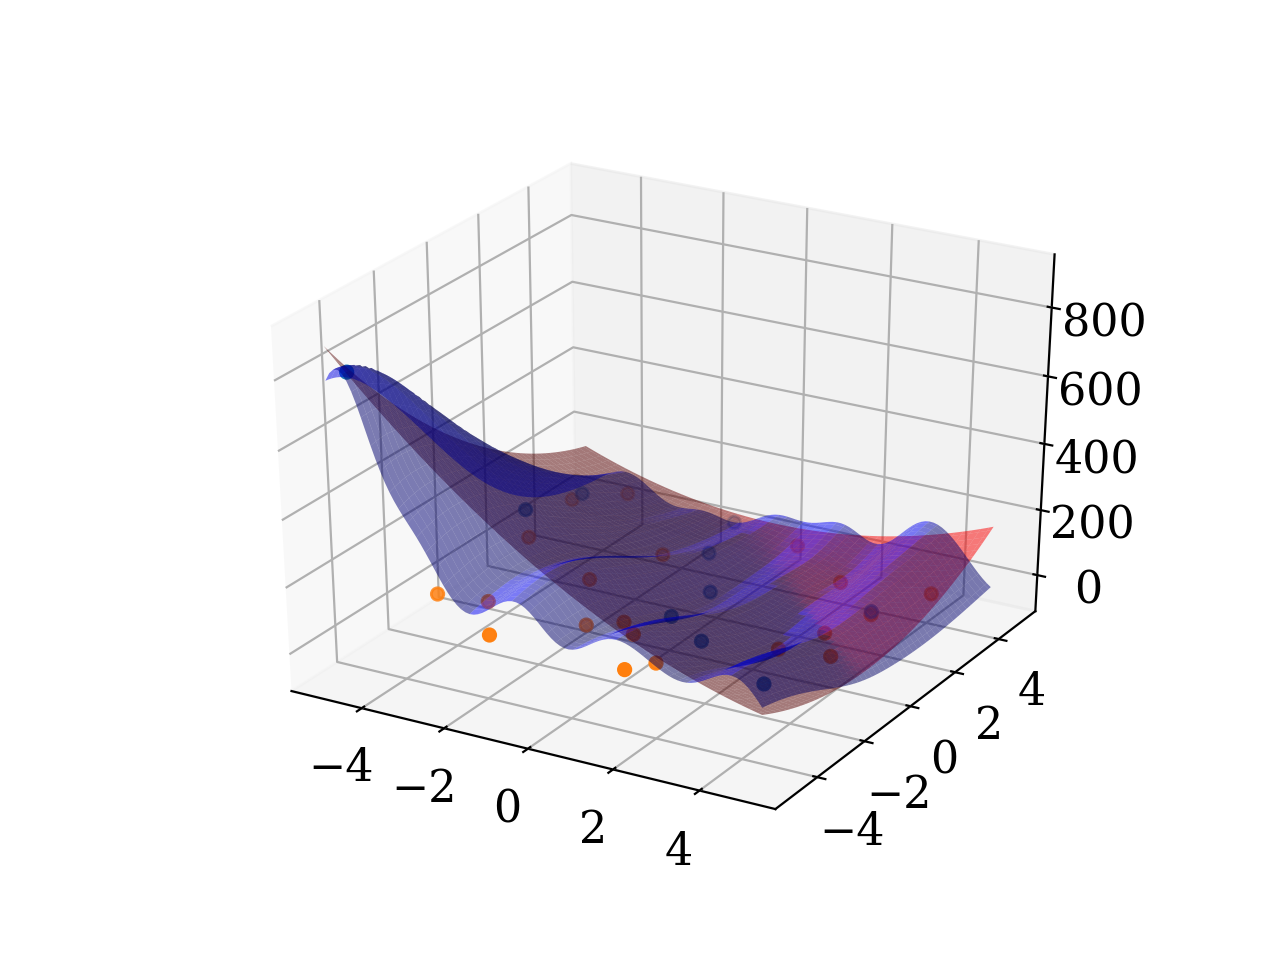

In [19]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_H[:,0], X_H[:,1], y_H)
ax.scatter(X_L[:,0],X_L[:,1], y_L)

ax.plot_surface(xx, yy, y_star, label = "Exact", color = "r", alpha=0.5)
ax.plot_surface(xx, yy, y_pred, label = "Prediction", color = "b",alpha=0.5)
#ax.plot_surface(xx,yy,y_var.T.reshape(nn,nn), label="Var", alpha=0.25)
plt.show()


In [20]:
def rastrigin(X):
    #n-D
    #optimum at X=[0,...,0], f(X)=0
    X = np.atleast_2d(X)
    return(10*len(X[0])+np.sum(np.power(X,2)-10*np.cos(2*np.pi*X),1))

In [21]:
def rastrigin_l(X):
    X = np.atleast_2d(X)
    return(0.8 * rastrigin(X)+X[:,0]**2+X[:,1]**2)

In [22]:
N_H = 100
N_L = 200
D = 2
lb = -5.12
ub = 5.12
noise_L = 0.00
noise_H = 0.00

[[57.84942745 54.14476436 54.51651279 ... 54.51651279 54.14476436
  57.84942745]]


<IPython.core.display.Javascript object>


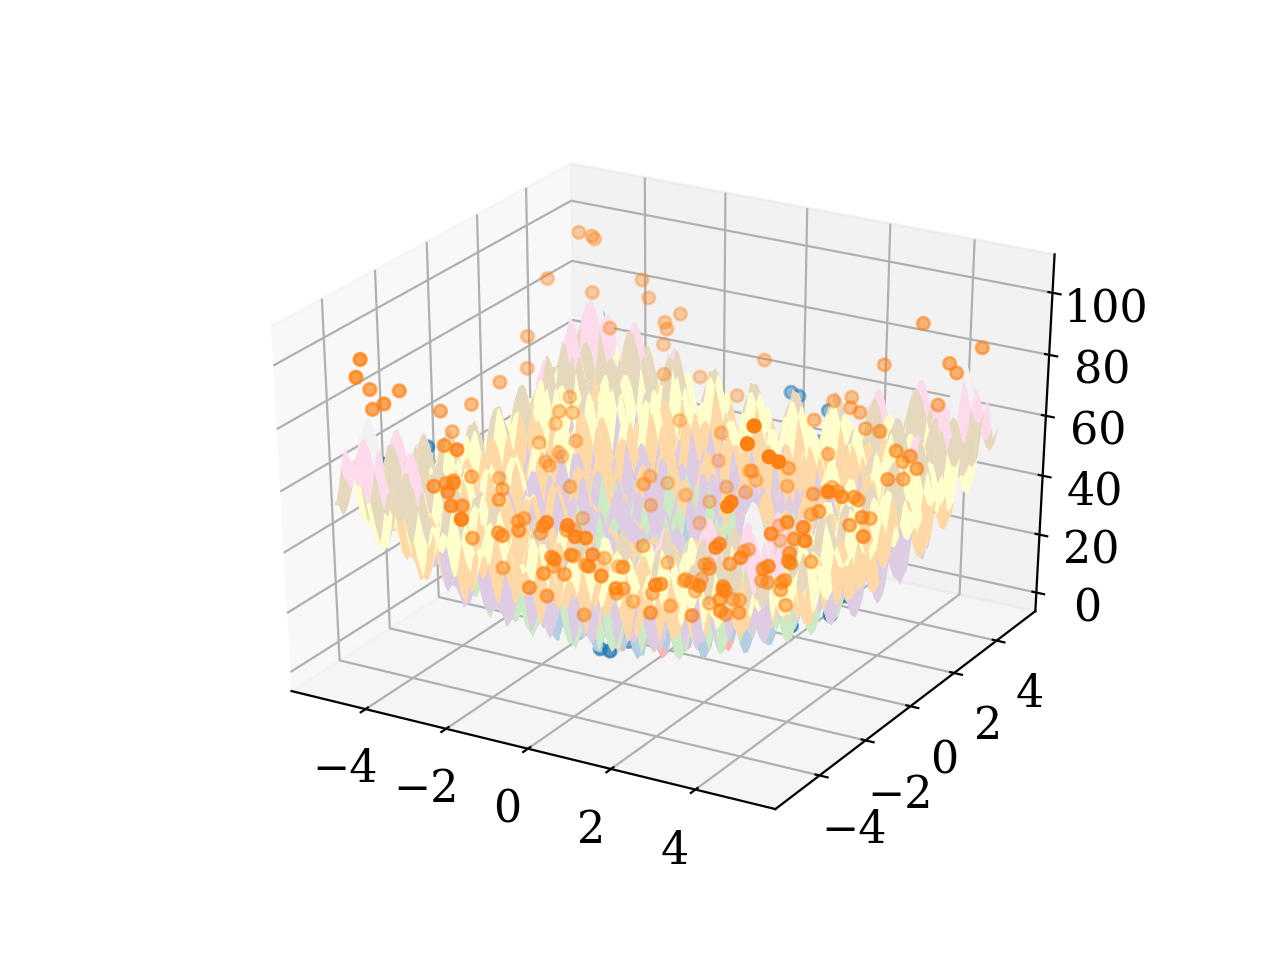

In [23]:
# Training data    
X_L = lb + (ub-lb)*lhs(D, N_L)
y_L = rastrigin_l(X_L)
y_L = np.atleast_2d(y_L).T

X_H = lb + (ub-lb)*lhs(D, N_H)
y_H = rastrigin(X_H)
y_H = np.atleast_2d(y_H).T

# Test data
nn = 100
x_star = np.linspace(lb, ub, nn)
xx, yy = np.meshgrid(x_star, x_star)

X_star = []
for i in x_star:
    for n in x_star:
        X_star.append([i,n])
X_star = np.array(X_star)
y_star_temp = np.array([rastrigin(X_star)])
print(y_star_temp)
y_star = y_star_temp.reshape(nn,nn)

# Plot the training data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_H[:,0], X_H[:,1], y_H)
ax.scatter(X_L[:,0],X_L[:,1], y_L)
ax.plot_surface(xx, yy, y_star, cmap=cm.Pastel1)
plt.show()

In [24]:
# Define model
model = Multifidelity_GP(X_L, y_L, X_H, y_H)

Total number of parameters: 9


In [25]:
# Train 
model.train()

Log likelihood 122136.44316553081
Log likelihood 59667.959309375416
Log likelihood 28733.272042202916
Log likelihood 14537.716961895641
Log likelihood 14537.716961895641


In [26]:
# Predict
y_pred, y_var = model.predict(X_star)

In [27]:
print(y_star_temp.T[y_pred==y_pred.min()])

[47.15402535]


In [28]:
y_var = np.abs(np.diag(y_var))
y_pred = y_pred.T.reshape(nn,nn)
# Check accuracy                       
error = np.linalg.norm(y_pred-y_star,2)/np.linalg.norm(y_star,2)
print(f"Relative L2 error u: {error}")

Relative L2 error u: 0.1855473561327424


<IPython.core.display.Javascript object>


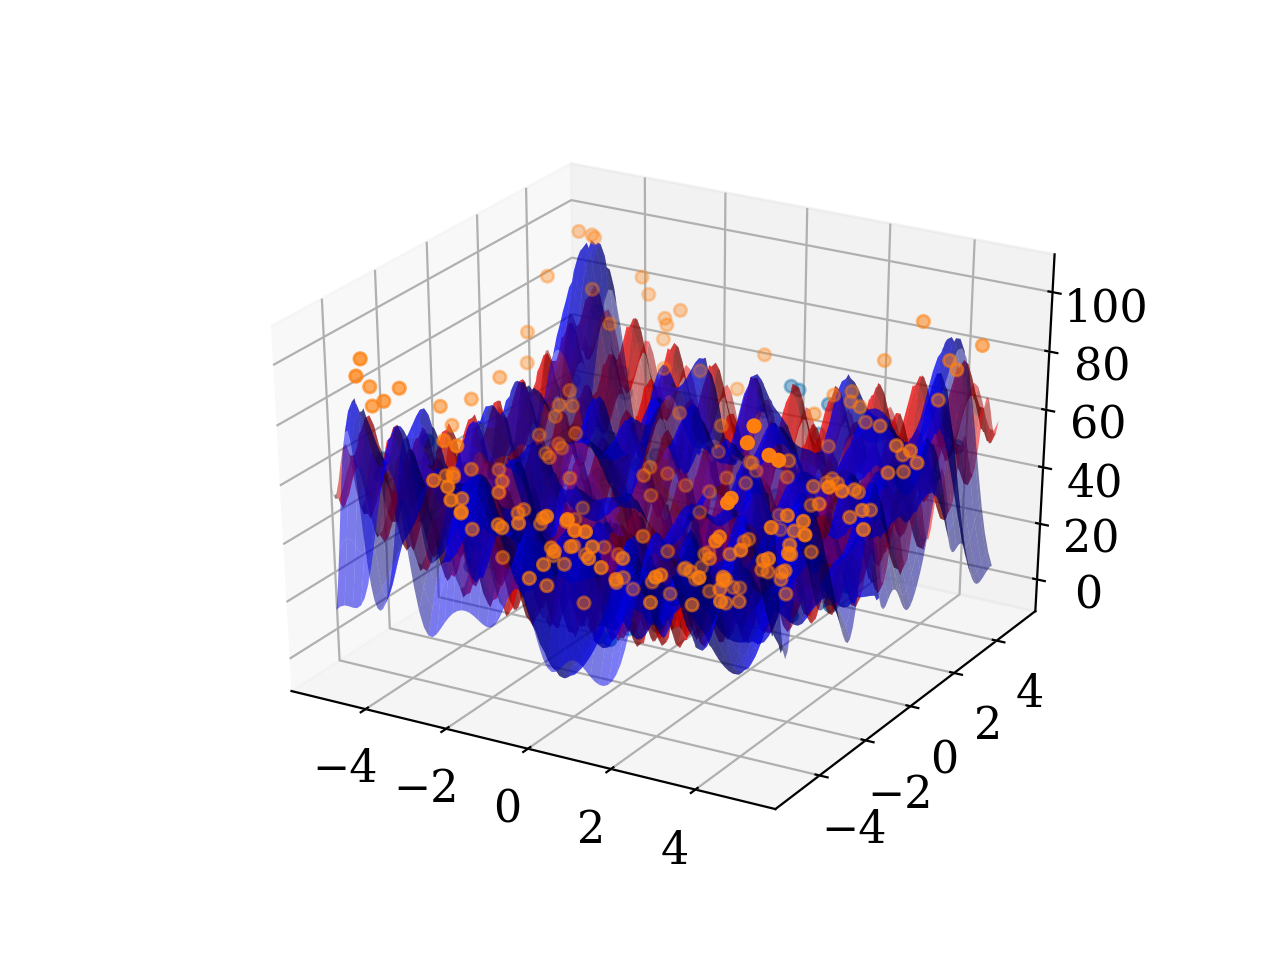

In [29]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_H[:,0], X_H[:,1], y_H)
ax.scatter(X_L[:,0],X_L[:,1], y_L)

ax.plot_surface(xx, yy, y_star, label = "Exact", color = "r", alpha=0.5)
ax.plot_surface(xx, yy, y_pred, label = "Prediction", color = "b",alpha=0.5)
#ax.plot_surface(xx,yy,y_var.T.reshape(nn,nn), label="Var", alpha=0.25)
plt.show()


In [30]:
print(np.argsort((y_pred+y_var.T.reshape(nn,nn)).flatten()))
print(X_star[np.argsort((y_pred+y_var.T.reshape(nn,nn)).flatten())])

[3146 3147 1843 ... 9405 9205 9305]
[[-1.91353535 -0.3620202 ]
 [-1.91353535 -0.25858586]
 [-3.25818182 -0.67232323]
 ...
 [ 4.60282828 -4.60282828]
 [ 4.3959596  -4.60282828]
 [ 4.49939394 -4.60282828]]


In [31]:
def sphere(X):
    #n-D
    #optimum at X = [0,...,0], f(X)=0
    X = np.atleast_2d(X)
    return(np.sum(np.power(X,2), 1))

In [32]:
def sphere_l(X):
    X = np.atleast_2d(X)
    Y = sphere(X)
    return(0.7*Y + X[:,0]**2+3*X[:,1])

In [33]:
N_H = 50
N_L = 500
D = 12
lb = -1.0
ub = 1.0
noise_L = 0.1
noise_H = 0.1

In [34]:
# Training data    
X_L = lb + (ub-lb)*lhs(D, N_L)
y_L = rastrigin_l(X_L)
y_L = np.atleast_2d(y_L).T

X_H = lb + (ub-lb)*lhs(D, N_H)
y_H = rastrigin(X_H)
y_H = np.atleast_2d(y_H).T

# Test data
nn = 100
X_star = np.random.rand(nn,D)
print(X_star)
y_star = np.array([rastrigin(X_star)]).T
print(y_star)
"""
# Plot the training data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_H[:,0], X_H[:,1], y_H)
ax.scatter(X_L[:,0],X_L[:,1], y_L)
ax.plot_surface(xx, yy, y_star, cmap=cm.Pastel1)
plt.show()
"""

[[0.18976767 0.29487515 0.99833673 ... 0.90353825 0.3954516  0.11499996]
 [0.27827145 0.21173375 0.20796123 ... 0.8433562  0.29383635 0.84025321]
 [0.14878511 0.6098016  0.48958966 ... 0.12828887 0.36097168 0.05421066]
 ...
 [0.35003032 0.52637446 0.3059178  ... 0.72601991 0.14303574 0.21158608]
 [0.33742223 0.19079611 0.07056002 ... 0.28018335 0.25508709 0.63231649]
 [0.28488074 0.78176712 0.3072651  ... 0.11065344 0.377134   0.85631662]]
[[107.24090327]
 [119.20795483]
 [113.73484324]
 [128.98855839]
 [ 83.45036262]
 [123.73481772]
 [162.31278166]
 [105.48190118]
 [135.22873464]
 [172.43909754]
 [189.76530033]
 [ 97.29107034]
 [104.15918603]
 [112.54986011]
 [126.08336012]
 [102.84032006]
 [121.78084927]
 [ 92.05796899]
 [ 67.89998541]
 [138.09328681]
 [160.47899142]
 [137.50812321]
 [128.41529063]
 [122.54505915]
 [121.19180134]
 [106.99494252]
 [ 76.25272571]
 [135.42832793]
 [126.33240554]
 [161.9391289 ]
 [ 82.40710194]
 [117.94638339]
 [144.30815387]
 [100.96196268]
 [104.083660

"\n# Plot the training data\nfig = plt.figure()\nax = fig.add_subplot(111, projection='3d')\n\nax.scatter(X_H[:,0], X_H[:,1], y_H)\nax.scatter(X_L[:,0],X_L[:,1], y_L)\nax.plot_surface(xx, yy, y_star, cmap=cm.Pastel1)\nplt.show()\n"

In [35]:
# Define model
model = Multifidelity_GP(X_L, y_L, X_H, y_H)

Total number of parameters: 29


In [36]:
# Train 
model.train()

Log likelihood 185109.40387646065
Log likelihood 99200.34629342207
Log likelihood 99200.34629342207


In [37]:
# Predict
y_pred, y_var = model.predict(X_star)
y_var = np.abs(np.diag(y_var))
# Check accuracy                       
error = np.linalg.norm(y_pred-y_star,2)/np.linalg.norm(y_star,2)
print(f"Relative L2 error u: {error}")

Relative L2 error u: 0.22455308344047029


In [38]:
print(y_star[y_pred==y_pred.min()])

[88.84802376]


In [39]:
print(y_pred.min())

75.26176125981016
